The goal is to check that the three algorithms multiviewica, ShICA-J, and ShICA-ML work correctly.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from picard import amari_distance

from multiviewica import multiviewica
from shica import shica_j, shica_ml
import lingam

# sample variables

In [27]:
# parameters
m = 5
p = 4
n = 1000
nb_gaussian_sources = 4  # should be between 0 and p
random_state = 42
rng = np.random.RandomState(random_state)

In [28]:
# sources
S_ng = rng.laplace(size=(p-nb_gaussian_sources, n))
S_g = rng.normal(size=(nb_gaussian_sources, n))
S = np.vstack((S_ng, S_g))

# noise
sigmas = np.ones((m, p)) * 1 / 2
if nb_gaussian_sources != 0:
    sigmas[:, -nb_gaussian_sources:] = rng.uniform(size=(m, nb_gaussian_sources))
N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))

# mixing matrices
A = rng.normal(size=(m, p, p))

# observations
X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])

# plot X, S, and N

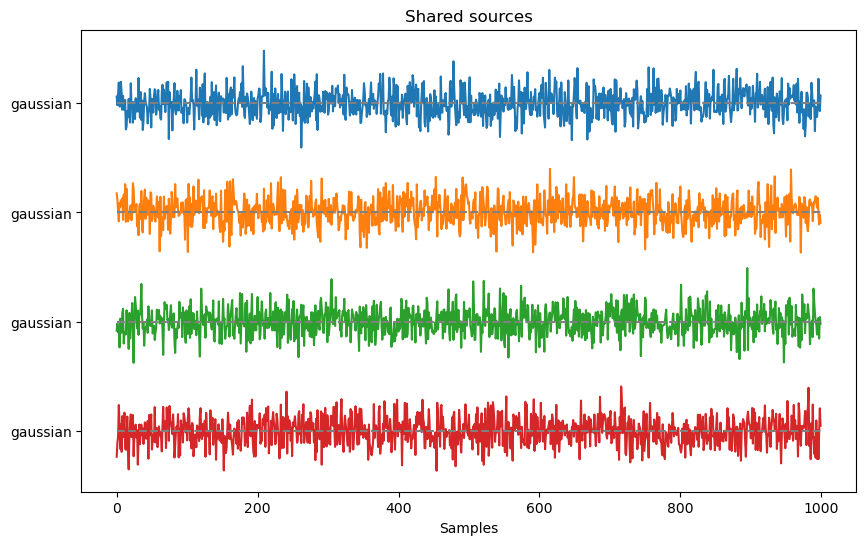

In [29]:
# plot sources
def plot_sources(S, nb_gaussian_sources, height=8):
    p, n = S.shape
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(p):
        plt.plot(S[i] - height * i)
        plt.hlines(y=-height*i, xmin=0, xmax=n, linestyles="--", colors="grey")
    plt.xlabel("Samples")
    plt.yticks(-np.arange(p) * height)
    yticklabels = ["non-gaussian"] * (p - nb_gaussian_sources) + ["gaussian"] * nb_gaussian_sources
    ax.set_yticklabels(yticklabels)
    plt.title("Shared sources")
    plt.show()

plot_sources(S, nb_gaussian_sources)

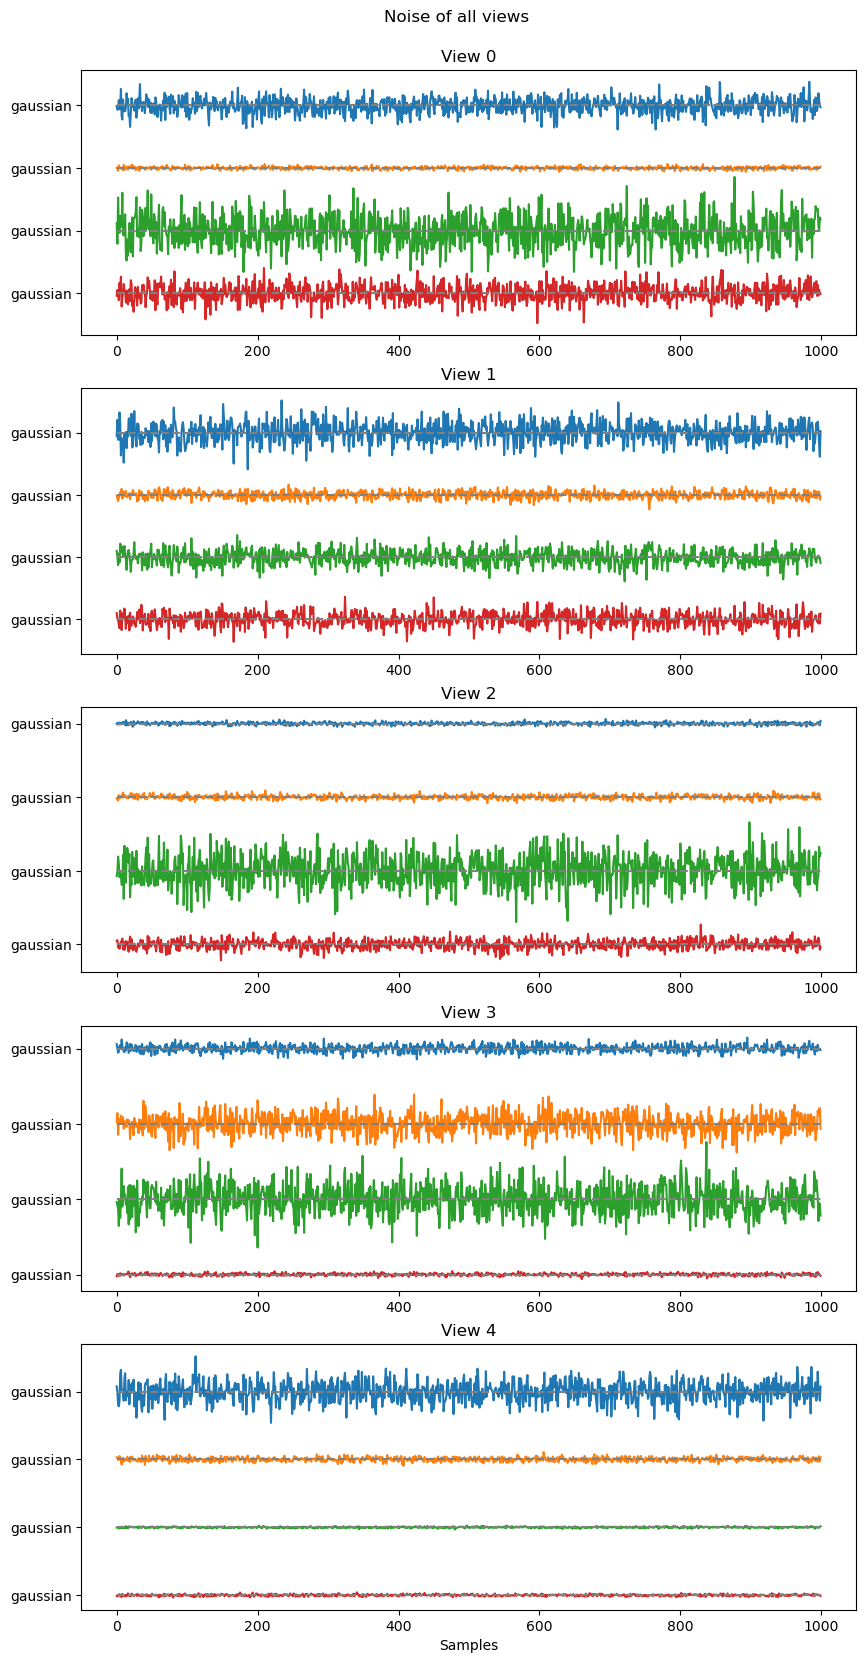

In [30]:
# plot noise
def plot_noise(N, nb_gaussian_sources, height=4):
    m, p, n = N.shape
    fig, axes = plt.subplots(m, 1, figsize=(10, 4*m))
    for i in range(m):
        for j in range(p):
            axes[i].plot(N[i, j] - height * j)
            axes[i].hlines(y=-height*j, xmin=0, xmax=n, linestyles="--", colors="grey")
        axes[i].set_yticks(-np.arange(p) * height)
        yticklabels = ["non-gaussian"] * (p - nb_gaussian_sources) + ["gaussian"] * nb_gaussian_sources
        axes[i].set_yticklabels(yticklabels)
        axes[i].set_title(f"View {i}")
    plt.xlabel("Samples")
    plt.suptitle("Noise of all views", y=0.91)
    plt.show()

plot_noise(N, nb_gaussian_sources)

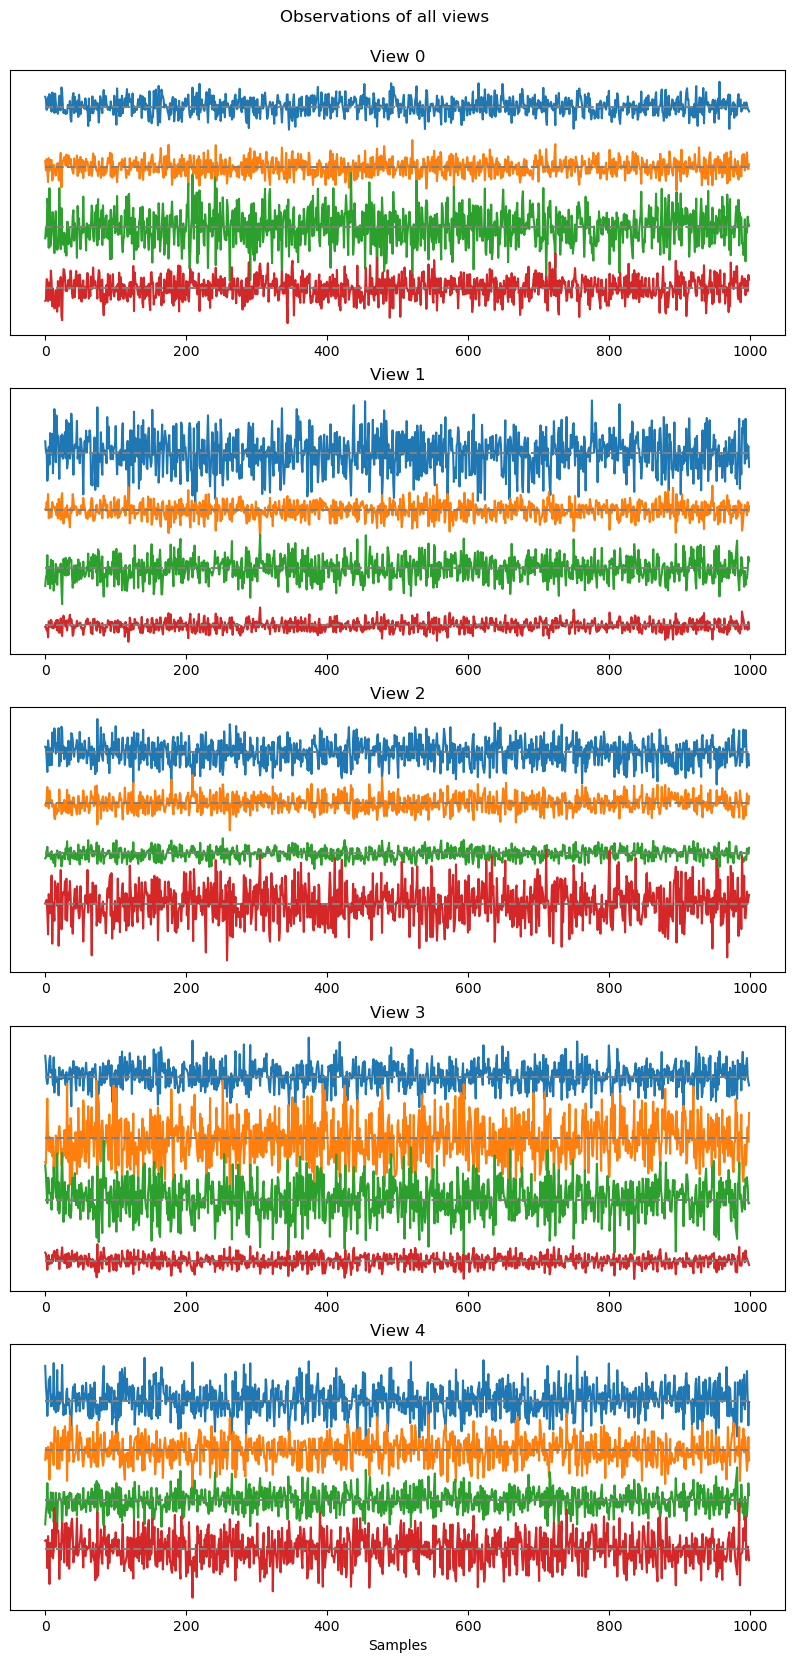

In [31]:
# plot observations
def plot_observations(X, height=10):
    m, p, n = X.shape
    fig, axes = plt.subplots(m, 1, figsize=(10, 4*m))
    for i in range(m):
        for j in range(p):
            axes[i].plot(X[i, j] - height * j)
            axes[i].hlines(y=-height*j, xmin=0, xmax=n, linestyles="--", colors="grey")
        axes[i].set_yticks([])
        axes[i].set_title(f"View {i}")
    plt.xlabel("Samples")
    plt.suptitle("Observations of all views", y=0.91)
    plt.show()

plot_observations(X)

# ICA

In [32]:
# multiviewica
_, W_mvica, S_mvica = multiviewica(X, max_iter=1000, tol=1e-3, random_state=random_state)
amari_mvica = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_mvica, A)])
amari_mvica

0.4090268065256505

In [33]:
# ShICA-J
W_shica_j, sigmas_shica_j, S_shica_j = shica_j(X, max_iter=10000, tol=1e-5)
amari_shica_j = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_shica_j, A)])
amari_shica_j

0.0019495397298382455

In [35]:
# ShICA-ML
W_shica_ml, sigmas_shica_ml, S_shica_ml = shica_ml(X, max_iter=3000, tol=1e-8)
amari_shica_ml = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_shica_ml, A)])
amari_shica_ml

0.001594012279875362

When varying nb_gaussian_sources (0, 2, 4) and n (1e2, 1e3, 1e4), we obtain results similar to Fig. 2 in the ShICA paper.

## ICA-LiNGAM and MultiGroupDirectLiNGAM fail because A is not structured

In [36]:
# ICA-LiNGAM
B_lingam = []
model = lingam.ICALiNGAM()
for i in range(m):
    model.fit(np.swapaxes(X[i], 0, 1))
    B_estimate = np.array(model._adjacency_matrix)
    B_lingam.append(B_estimate)
B_lingam = np.array(B_lingam)
W_lingam = np.eye(p) - B_lingam
amari_lingam = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_lingam, A)])
amari_lingam

/storage/store2/work/aheurteb/miniconda3/envs/mvica_lingam/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


0.612350481285592

In [38]:
# apply Multi Group DirectLiNGAM to retrieve B, T, P, and W
model = lingam.MultiGroupDirectLiNGAM()
model.fit(list(np.swapaxes(X, 1, 2)))
# causal effect matrices B and T
B_MGDLiNGAM = np.array(model.adjacency_matrices_)
# reconstruct what would be unmixing matrices W
W_MGDLiNGAM = np.eye(p) - B_MGDLiNGAM
amari_MGDLiNGAM = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_MGDLiNGAM, A)])
amari_MGDLiNGAM

0.5972729830726873